[【PyTorch入門】PyTorchで手書き数字(MNIST)を学習させる - 株式会社ライトコード](https://rightcode.co.jp/blog/information-technology/pytorch-mnist-learning) を元に、@xhiroga が一部改変。

In [1]:
import torch
import torch.nn.functional as f
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # fc: Fully Connected Layerの略
        self.fc1 = torch.nn.Linear(28*28, 1000) # 28px * 28px の画像を 1000次元のベクトルに変換
        self.fc2 = torch.nn.Linear(1000, 10) # 1000次元のベクトルを 0~9 の10次元のベクトルに変換

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)

        return f.log_softmax(x, dim=1)


In [9]:
def load_MNIST(batch=128, intensity=1.0):
    train_dataset = datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.mul_(intensity)),
            ]
        ),
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x.mul_(intensity)),
                       ])),
        batch_size=batch, shuffle=True)

    return {'train': train_loader, 'test': test_loader}

In [10]:
def to_device(data, target, device):
    return data.to(device), target.to(device)

In [11]:
# Check if GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device:', device)

Using device: cuda


torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
Training log: 1 epoch (128 / 60000 train. data). Loss: 2.299816370010376
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
Training log: 1 epoch (1408 / 60000 train. data). Loss: 1.8033852577209473
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 

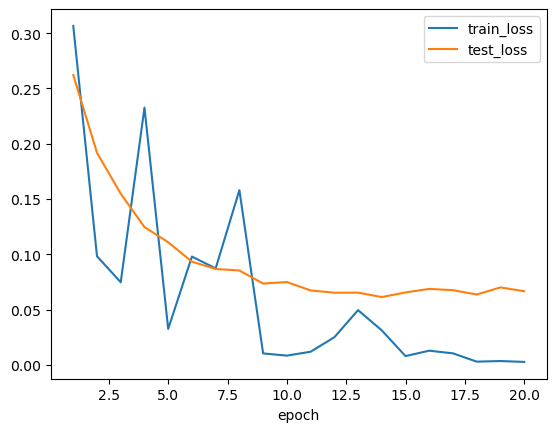

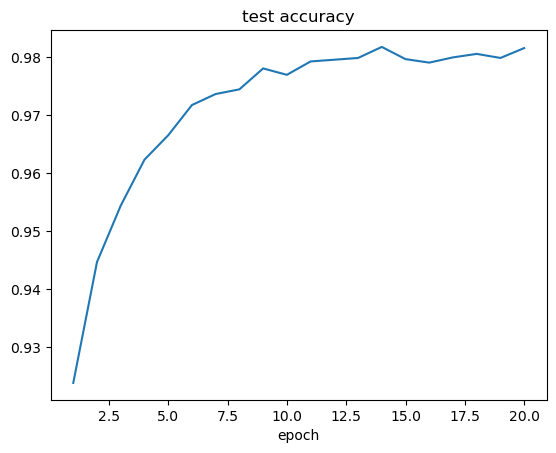

In [22]:
epoch = 20
# epoch = 3 # for debug

history = {
    "train_loss": [],
    "test_loss": [],
    "test_acc": [],
}

net: torch.nn.Module = MyNet().to(device)

loaders = load_MNIST()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for e in range(epoch):
    """Train Part"""
    loss = None

    net.train(True)
    for i, (data, target) in enumerate(loaders["train"]):
        data, target = to_device(data, target, device)
        print(data.shape)
        data = data.view(-1, 28 * 28)
        print(data.shape)

        optimizer.zero_grad()
        output = net(data)
        loss = f.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(
                "Training log: {} epoch ({} / 60000 train. data). Loss: {}".format(
                    e + 1, (i + 1) * 128, loss.item()
                )
            )

    history['train_loss'].append(loss)

    """Test Part"""
    net.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = to_device(data, target, device)
            data = data.view(-1, 28 * 28).to(device)
            output = net(data)
            test_loss += f.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # len(loaders["test"].dataset) ではなく？
    test_loss /= 10000

    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                        correct / 10000))

    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)

# 結果の出力と描画
print(history)
plt.figure()
plt.plot(range(1, epoch+1), [loss.cpu().item() for loss in history['train_loss']], label='train_loss')
plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')  # こちらは数値なのでそのままでOK
plt.xlabel('epoch')
plt.legend()
plt.savefig('assets/loss.png')

plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('assets/test_acc.png')
